# Wine Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.datasets import WineDataset
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist, plot_residuals_analysis, check_seasonality, seasonal_decompose

from darts.metrics import mae, mape, mase, r2_score
from darts.models import (
    NaiveDrift,
    NaiveSeasonal,
    ARIMA,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)

from darts_forecasting_utils import *

In [2]:
wine = WineDataset().load()

## Data Description 

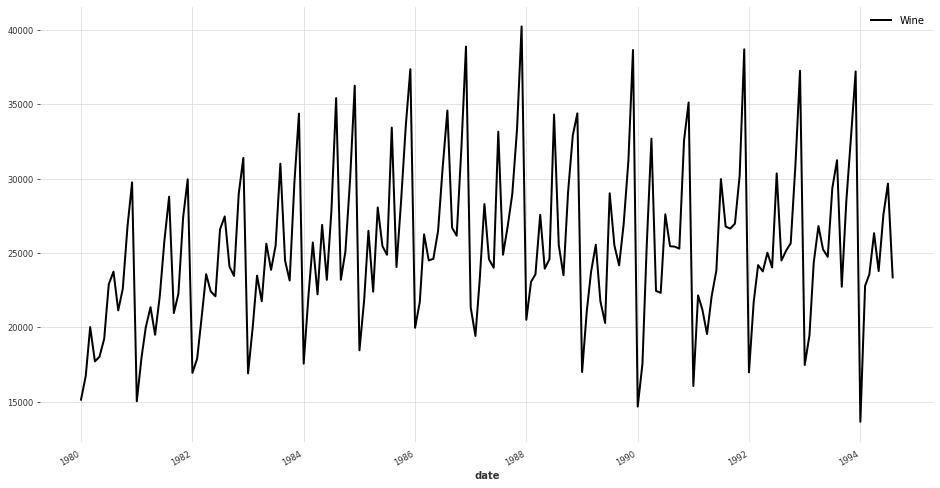

In [3]:
plot_time_series({'Wine': wine})

In [4]:
is_data_seasonal(wine, 24)

Seasonality of degree 4 found!
Seasonality of degree 8 found!
Seasonality of degree 12 found!
Seasonality of degree 16 found!
Seasonality of degree 20 found!


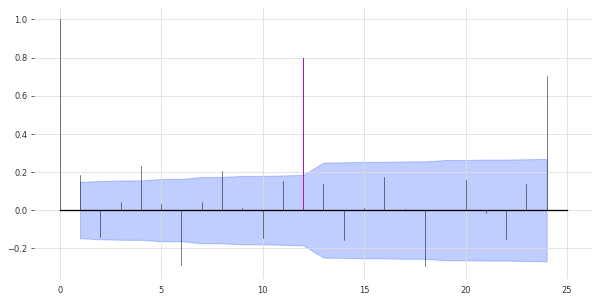

In [5]:
plot_acf(wine, m=12)

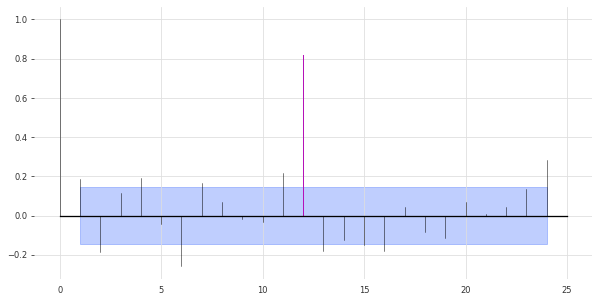

In [6]:
plot_pacf(wine, m=12)

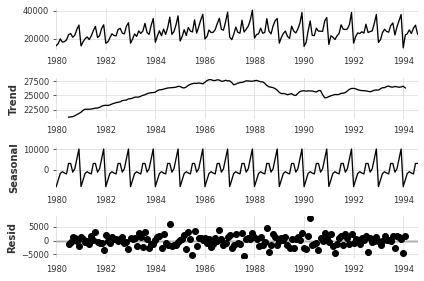

In [7]:
seasonal = seasonal_decompose(wine.pd_dataframe())
_ = seasonal.plot()

## Model Choosing

In [8]:
train, test = wine.split_before(pd.Timestamp('19930101'))

In [9]:
models = (
    NaiveDrift(),
    NaiveSeasonal(K=4),
    NaiveSeasonal(K=12),
    AutoARIMA(),
    ExponentialSmoothing(seasonal_periods=12),
    Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    ),
    Theta(seasonality_period=12)
)   

In [10]:
best_model = get_best_model(models, train, mape, stride=6, num_periods=12)

Naive drift model : 25.85912964248484
Naive seasonal model, with K=4 : 18.309228567263784
Naive seasonal model, with K=12 : 9.241890275522168
Auto-ARIMA : 17.58327357160689
Exponential smoothing : 9.319658946329223
Prophet : 9.996032819527619
Theta(2) : 9.188517561563136


## Parameter Tuning

In [11]:
theta_grid = {'theta': np.linspace(-10, 10, 10),
              'seasonality_period': [12]}
theta_model = Theta()

theta_model = theta_model.gridsearch(
    parameters=theta_grid,
    series=train,
    stride=1,
    forecast_horizon=12,
    n_jobs=-1,
)[0]

## Performance Evaluation

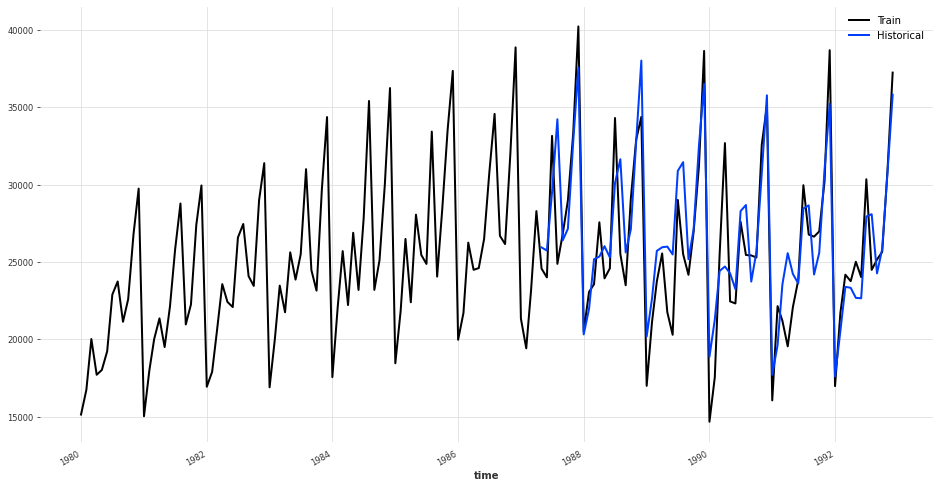

In [13]:
historical = theta_model.historical_forecasts(
    train,
    stride=1,
    forecast_horizon=12,
)
plot_time_series({'Train': train, 'Historical': historical})

In [14]:
backtest_errors = theta_model.backtest(
    train,
    stride=1,
    forecast_horizon=12,
    metric=mape,
    reduction=None
)

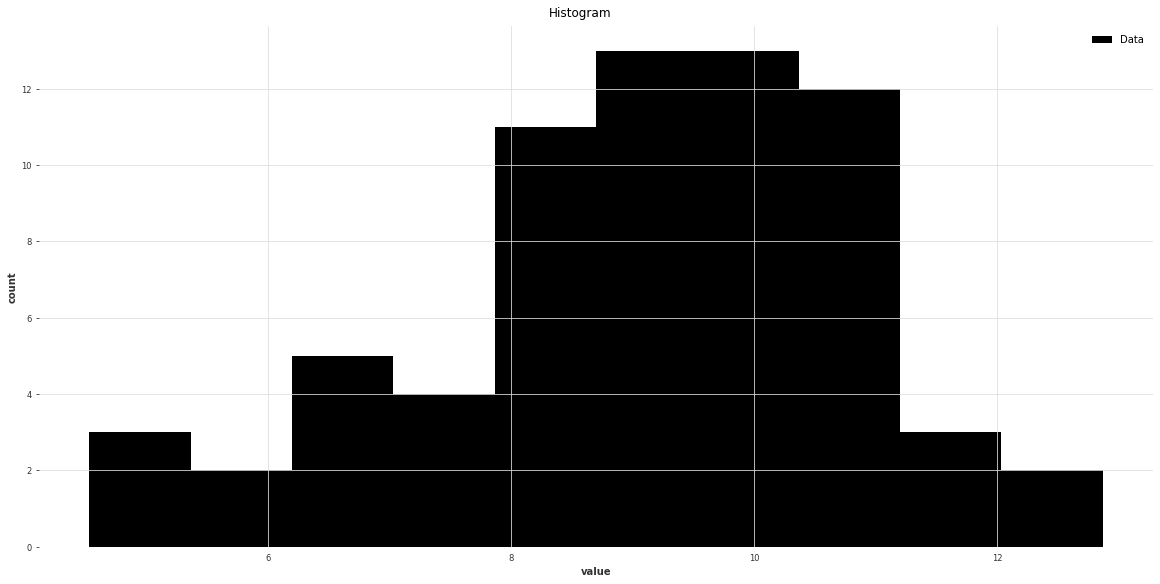

In [16]:
plot_hist(backtest_errors, fig_size=(16, 8))

## Predictions 

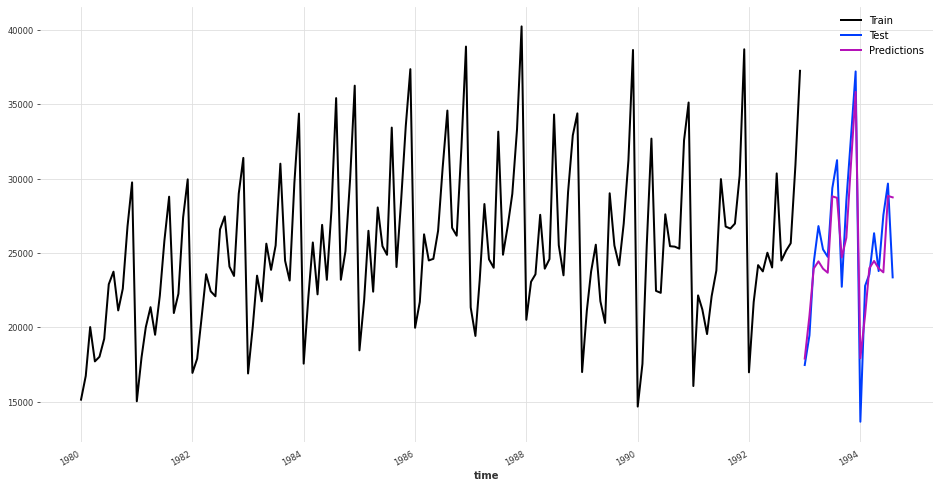

In [18]:
theta_model.fit(train)
preds = theta_model.predict(len(test))

plot_time_series({'Train': train, 'Test': test, 'Predictions': preds})

## Conclusions